# Лабораторная работа 5. Математическое прогнозирование

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from peft import get_peft_model, LoraConfig, PrefixTuningConfig, TaskType
from transformers import BertModel
import torch.nn as nn
from transformers import TrainerCallback
from transformers import pipeline
from transformers import logging
logging.set_verbosity_warning()  

Зафиксируем random_state для воспроизводимости

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Подгрузим модель и данные

In [ ]:
dataset = load_dataset("dair-ai/emotion")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Выполним небольную предобработку и токенизацию данных для дальнейшей работы. Кроме того, определим метрики

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

results = []

In [ ]:
pipe = pipeline("text-classification", model=model_name, tokenizer=tokenizer, top_k=1)

texts = dataset['validation']['text']
pipe_outputs = pipe(texts, batch_size=16) 
preds = [int(output[0]['label'].split('_')[-1]) for output in pipe_outputs]

labels = dataset['validation']['label']
baseline_accuracy = accuracy_metric.compute(predictions=preds, references=labels)
print(f"Baseline accuracy: {baseline_accuracy['accuracy']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Baseline accuracy: 0.3415


Первичная оценка модели до обучения показывает, что данные модели не особо знакомы, так как точность классификации очень низкая

Определим общую функцию для всех наших циклов обучения

In [ ]:
logs_by_model = {}

def evaluate_model(method_name, model, trainer):
    epoch_logs = []

    class LoggingCallback(TrainerCallback):
        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs is not None and "loss" in logs:
                logs_copy = logs.copy()
                logs_copy["epoch"] = state.epoch
                epoch_logs.append(logs_copy)

        def on_evaluate(self, args, state, control, metrics=None, **kwargs):
            if metrics is not None and "eval_accuracy" in metrics:
                metrics_copy = metrics.copy()
                metrics_copy["epoch"] = state.epoch
                epoch_logs.append(metrics_copy)

    trainer.add_callback(LoggingCallback)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

    epoch_logs.append({
        "epoch": trainer.state.epoch,
        "training_time": training_time,
        "gpu_memory_MB": gpu_memory
    })

    logs_by_model[method_name] = epoch_logs
    last_eval = next((log for log in reversed(epoch_logs) if "eval_accuracy" in log), None)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    results.append({
        "Method": method_name,
        "Accuracy": last_eval["eval_accuracy"] if last_eval else None,
        "Training Time (s)": round(training_time, 2),
        "Trainable Params": trainable_params,
        "GPU Memory (MB)": round(gpu_memory, 2)
    })

    if last_eval:
        print(f"{method_name} — Accuracy: {last_eval['eval_accuracy']:.4f}, "
              f"Time: {training_time:.2f}s, "
              f"Params: {trainable_params}, "
              f"GPU Mem: {gpu_memory:.2f} MB")

### Обучение модели в режиме full finetuning

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
args = TrainingArguments(
    output_dir="/results_full",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="/logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
evaluate_model("Full Finetuning", model, trainer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\4211656436.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.238800,0.221843,0.929000
2,0.148100,0.170113,0.934000
3,0.109100,0.176326,0.939500
4,0.088000,0.207388,0.934500
5,0.064600,0.270862,0.933000
6,0.045500,0.288868,0.935500
7,0.019600,0.319744,0.934000


Full Finetuning — Accuracy: 0.9340, Time: 2472.60s, Params: 109486854, GPU Mem: 2154.61 MB


### Обучение модели в режиме linear probing

Здесь используем nn.Linear без скрытых слоёв для головы. Такая простая структура позволит оценить, насколько хорошо эмбеддинги предобученной модели уже захватывают информацию для классификации. 

In [ ]:
class BertWithLinearHead(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        logits = self.classifier(outputs.pooler_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

model_lp = BertWithLinearHead(pretrained_model_name=model_name, num_labels=6)
for param in model_lp.bert.parameters():
    param.requires_grad = False
args_lp = TrainingArguments(
    output_dir="/results_linear",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.0,
    logging_dir="/logs_linear",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)
trainer_lp = Trainer(
    model=model_lp,
    args=args_lp,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
evaluate_model("Linear Probing", model_lp, trainer_lp)

C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\3795150309.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.513400,1.512570,0.388000
2,1.453300,1.435133,0.488500
3,1.429600,1.408706,0.491000
4,1.402800,1.398646,0.493000
5,1.394900,1.375626,0.504000
6,1.380900,1.374592,0.498500
7,1.376300,1.363292,0.503000


Linear Probing — Accuracy: 0.5030, Time: 894.46s, Params: 4614, GPU Mem: 1737.21 MB


### Обучение модели в режиме PEFT с использованием prefix tuning

Здесь используем Prefix Tuning, который добавляет виртуальные токены к началу последовательности, не изменяя основные веса модели. Это компромисс между вычислительной эффективностью и качеством — он требует меньше ресурсов, чем полное дообучение, и обеспечивает довольно неплохое качество при небольшом числе дообучаемых параметров.

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
peft_config_prefix = PrefixTuningConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=20
)
model_prefix = get_peft_model(base_model, peft_config_prefix)
args_prefix = TrainingArguments(
    output_dir="/results_prefix",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="/logs_prefix",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)
trainer_prefix = Trainer(
    model=model_prefix,
    args=args_prefix,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
evaluate_model("Prefix Tuning", model_prefix, trainer_prefix)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\895215670.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_prefix = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.554200,1.497823,0.484500
2,1.457000,1.389135,0.567500
3,1.322000,1.224588,0.656500
4,1.197100,1.125810,0.689000
5,1.153300,1.078306,0.706000
6,1.121900,1.054443,0.717500
7,1.111800,1.048522,0.721000


Prefix Tuning — Accuracy: 0.7210, Time: 1502.36s, Params: 368640, GPU Mem: 2745.00 MB


### Обучение модели в режиме PEFT с использованием LoRA

Значение r=8 выбрано в качестве компромисса между числом параметров и качеством, эксперименты показали, что именно такое значение является оптимальным для данной задачи, lora_alpha=16 даёт масштаб на адаптеры, dropout=0.1 снижает переобучение

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)
model_lora = get_peft_model(base_model, lora_config)
args_lora = TrainingArguments(
    output_dir="/results_lora",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="/logs_lora",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1
)
trainer_lora = Trainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
evaluate_model("LoRA", model_lora, trainer_lora)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Таня\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\709200356.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.377600,0.325156,0.891500
2,0.248200,0.212906,0.918000
3,0.182500,0.184436,0.931000
4,0.159500,0.205349,0.932500
5,0.126500,0.171208,0.932500
6,0.108300,0.160157,0.940500
7,0.079100,0.160687,0.940000


LoRA — Accuracy: 0.9400, Time: 1550.57s, Params: 299526, GPU Mem: 3268.16 MB


### Результаты и выводы

In [11]:
df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Method          |   Accuracy |   Training Time (s) |   Trainable Params |   GPU Memory (MB) |
|:----------------|-----------:|--------------------:|-------------------:|------------------:|
| Full Finetuning |      0.934 |             2472.6  |          109486854 |           2154.61 |
| Linear Probing  |      0.503 |              894.46 |               4614 |           1737.21 |
| Prefix Tuning   |      0.721 |             1502.36 |             368640 |           2745    |
| LoRA            |      0.94  |             1550.57 |             299526 |           3268.16 |


Таким образом, можно сделать следующие выводы:
- Лучшую точность показал метод с применением LoRA, на втором месте full finetuning, который в отличие от LoRA задействует гораздо больше параметров и обучается дольше
- Худшие результаты показал Linear Probing, в этом методе низкая точность, хотя модель здесь обучалась быстрее всего и использовала минимум параметров (с чем скорее всего и связана низкая точность). Возможно концепция линейной головы оказалась слишком простой для этой задачи и в будущем при доработке можно будет попробовать что-то посложнее
- Full Finetuning обучается дольше всего, что связано с огромным (по сравнению с другими методами) количеством дообучаемых параметров.
- Prefix Tuning показал неплохие результаты, довольно хорошая точность при среднем времени обучения и количестве параметров
Как итог, для этой задачи лучшим решением является LoRA

Что касается графиков, можно отметить, что, например, Linear Probing  не нуждается в таком большом количестве эпох для обучения - accuracy перестает резко расти уже на 3 эпохе, а максимум точности достигается к 5 эпохе, потом же значния метрики начинают даже падать (возможно, имеет место переобучение, так как параметров мало).

Full Finetuning дает максимальную точность уже на 3 эпохе, а LoRA - на 5. В свою очередь, при использовании метода Prefix Tuning точность к 7 эпохе все так же продолжает расти, хотя и не так быстро, как в начале. Вероятно, здесь можно будет в будущем попробовать запустить обучение с количеством эпох побольше.

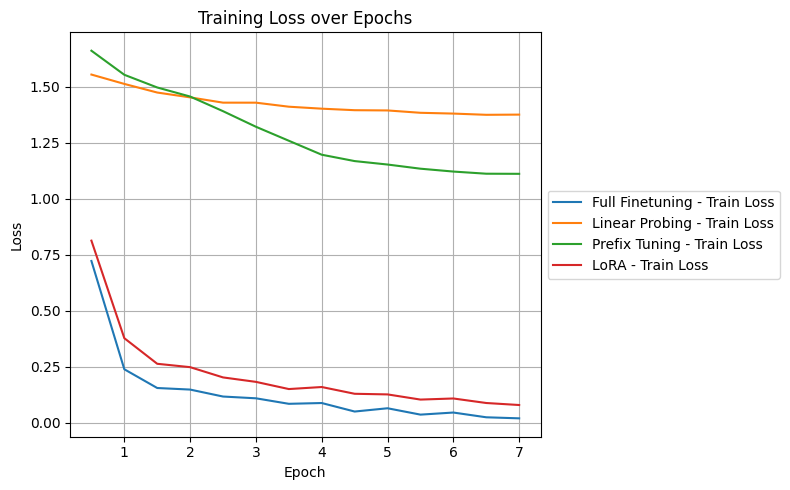

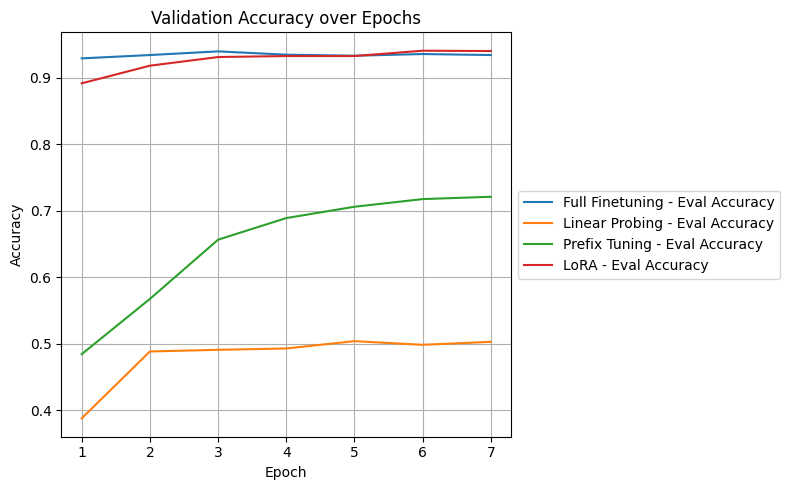

In [ ]:
def plot_logs_separately(logs_by_model):
    plt.figure(figsize=(8, 5))
    for method, logs in logs_by_model.items():
        epochs = [log["epoch"] for log in logs if "loss" in log]
        losses = [log["loss"] for log in logs if "loss" in log]
        if epochs and losses:
            plt.plot(epochs, losses, label=f"{method} - Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    for method, logs in logs_by_model.items():
        acc_epochs = [log["epoch"] for log in logs if "eval_accuracy" in log]
        accuracies = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
        if acc_epochs and accuracies:
            plt.plot(acc_epochs, accuracies, label=f"{method} - Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Epochs")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_logs_separately(logs_by_model)

C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\1052493660.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Method", data=df, palette="viridis")


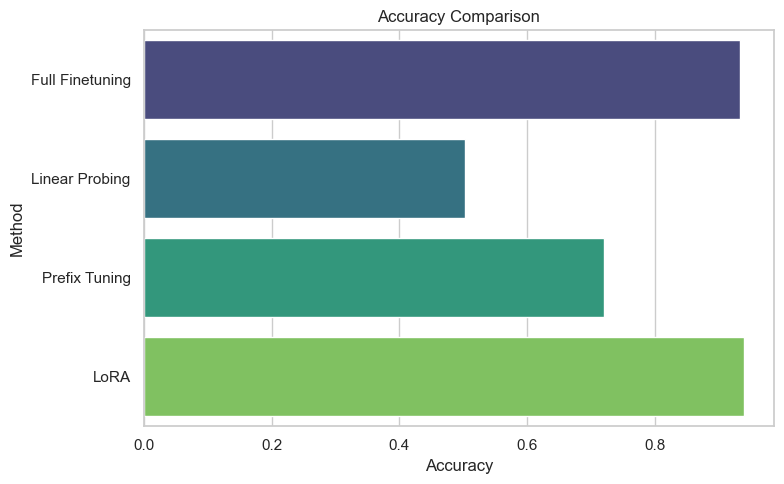

C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\1052493660.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Training Time (s)", y="Method", data=df, palette="magma")


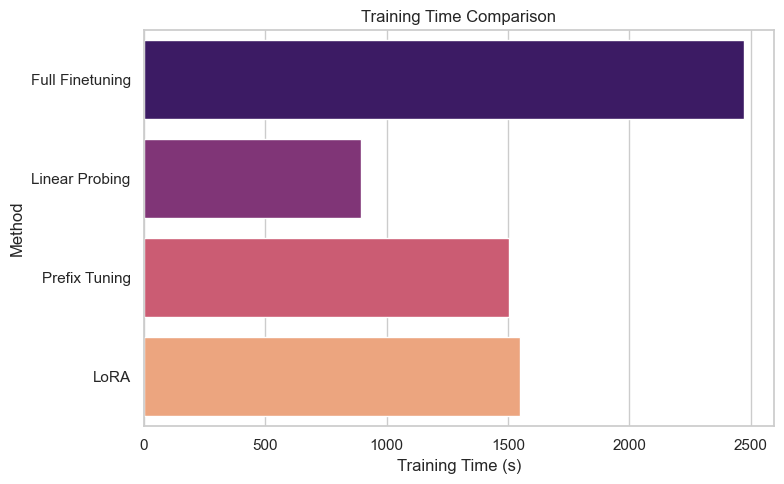

C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\1052493660.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="GPU Memory (MB)", y="Method", data=df, palette="coolwarm")


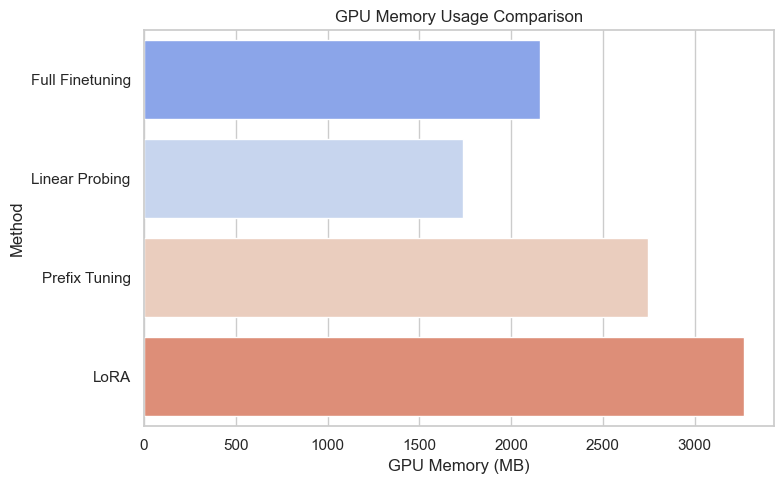

C:\Users\Таня\AppData\Local\Temp\ipykernel_15108\1052493660.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Trainable Params", y="Method", data=df, palette="cubehelix")


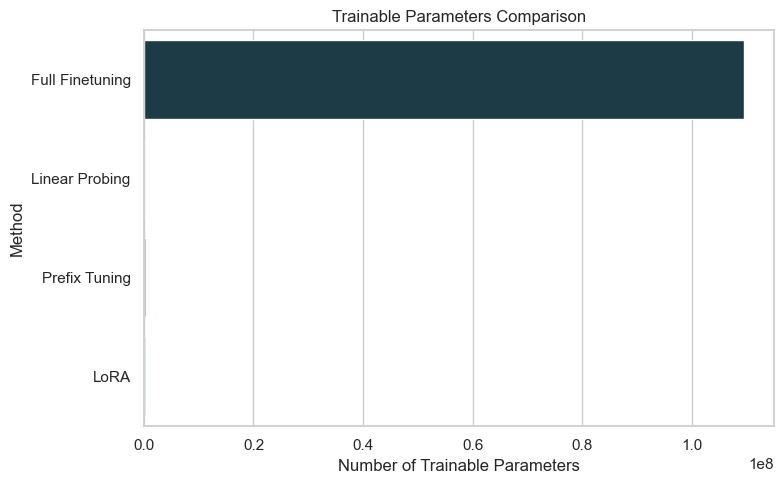

In [ ]:
def plot_results_table(results):
    df = pd.DataFrame(results)
    df["Method"] = df["Method"].astype(str)

    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Accuracy", y="Method", data=df, palette="viridis")
    plt.title("Accuracy Comparison")
    plt.xlabel("Accuracy")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Training Time (s)", y="Method", data=df, palette="magma")
    plt.title("Training Time Comparison")
    plt.xlabel("Training Time (s)")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x="GPU Memory (MB)", y="Method", data=df, palette="coolwarm")
    plt.title("GPU Memory Usage Comparison")
    plt.xlabel("GPU Memory (MB)")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Trainable Params", y="Method", data=df, palette="cubehelix")
    plt.title("Trainable Parameters Comparison")
    plt.xlabel("Number of Trainable Parameters")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.show()

plot_results_table(results)